# Estimation of IMC signal decay on fixed HEK cells on ibidi glass slide

The analytical workflow was written for Z:\users\ychian\Exp\202501_HRIMC_test

Tasks:
- Include nuclei segmentation to improve the estimation (dark pixel may lead to underestimation of IMC signal)
- Refer to IMC analysis workflow to see if they use any python package to remove hot pixels

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import scipy.ndimage

from readimc import MCDFile, TXTFile

In [2]:
work_dir = os.getcwd()
data_dir = os.path.join(work_dir, 'data')
exp_name = "20250204_QH_MALDI_OPS_SRIMC_test"
exp_dir = os.path.join(data_dir, exp_name + "\\" + exp_name)
# print(exp_dir)

# list out all the files in the directory
mcd_list = os.listdir(exp_dir)

print(mcd_list)

['20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-10_shot10_41.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-10_shot1_32.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-10_shot2_33.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-10_shot3_34.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-10_shot4_35.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-10_shot5_36.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-10_shot6_37.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-10_shot7_38.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-10_shot8_39.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-10_shot9_40.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-15_shot10_31.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-15_shot1_22.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-15_shot2_23.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-15_shot3_24.mcd', '20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-15_shot4_25.mcd', '20250204_QH_MALDI_OPS

In [3]:
output_dir = os.path.join(data_dir, exp_name + "\\output")

In [4]:
# build a dataframe out of the mcd_list
# define properties: image/decay, resolution, power respectively
# based on file_name[6], file_name[8], file_name[9]
# if "shot" is in the file_name, then record shot number # based on file_name[10] (remove the first 4 characters)
# if "shot" is not in the file_name, then record shot number as 1

# define the columns of the dataframe
columns = ['file_name', 'image_decay', 'resolution', 'power', 'shot', 'rep', 'id']
df = pd.DataFrame(columns=columns)
 
# loop through the mcd_list
for file_name in mcd_list:
    file_name_r = file_name
    if " - split" in file_name:
        file_name_r = file_name.replace(" - split", "")
    file_split = file_name_r.split("_")
    if "rep" in file_name: 
        rep = int(file_split[10][3:])
    else:
        rep = 1
    if "shot" in file_name:
        shot = int(file_split[10][4:])
    else:
        shot = 1
    
    # add new row to the dataframe, dataframe object has no attribute 'append'
    df.loc[len(df)] = [file_name, file_split[6], file_split[8], file_split[9], shot, rep, file_split[-1].split(".")[0]]

# set the data type of the columns
df = df.astype({'file_name': 'str', 'image_decay': 'str', 'resolution': 'float', 'power': 'int', 'shot': 'int', 'rep': 'int', 'id': 'str'})

In [5]:
df.head(70)

,file_name,image_decay,resolution,power,shot,rep,id
0,20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-...,decay,1.0,-10,10,1,41
1,20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-...,decay,1.0,-10,1,1,32
2,20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-...,decay,1.0,-10,2,1,33
3,20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-...,decay,1.0,-10,3,1,34
4,20250204_QH_MALDI_OPS_SRIMC_test_decay_pLL_1_-...,decay,1.0,-10,4,1,35
...,...,...,...,...,...,...,...
58,20250204_QH_MALDI_OPS_SRIMC_test_image_pLL_0.5...,image,0.5,-20,1,2,2
59,20250204_QH_MALDI_OPS_SRIMC_test_image_pLL_0.5...,image,0.5,-5,1,1,7
60,20250204_QH_MALDI_OPS_SRIMC_test_image_pLL_0.5...,image,0.5,-5,1,2,8
61,20250204_QH_MALDI_OPS_SRIMC_test_image_pLL_0.5...,image,0.5,0,1,1,9


In [6]:
# save the data frame as csv file
df.to_csv(os.path.join(output_dir, exp_name + '.csv'), index=False)

Set up the decay image groups

In [7]:
# set up the decay group
# store numerical list in the dictionary
decay_dict = {'-20db': list(range(12,22)), '-15db': list(range(22,32)), '-10db': list(range(32,42)), '-5db': list(range(42,52)), '0db': list(range(54,64))}
print(decay_dict)

{'-20db': [12, 13, 14, 15, 16, 17, 18, 19, 20, 21], '-15db': [22, 23, 24, 25, 26, 27, 28, 29, 30, 31], '-10db': [32, 33, 34, 35, 36, 37, 38, 39, 40, 41], '-5db': [42, 43, 44, 45, 46, 47, 48, 49, 50, 51], '0db': [54, 55, 56, 57, 58, 59, 60, 61, 62, 63]}


## Read in files

In [8]:
def read_imc_dict(file_big, id):
    #return a dictionary with three images: slide, panorama, imc
    with MCDFile(file_big) as f:
        slide = f.slides[0] # first slide
        panorama = slide.panoramas[0] # first panorama of first slide
        acquisition = slide.acquisitions[id]
        
        channel_labels = acquisition.channel_labels
        
        img_slide = f.read_slide(slide)
        img_panorama = f.read_panorama(panorama)
        img_imc = f.read_acquisition(acquisition)

        # put the image into a dictionary
        img_dict = {}
        img_dict['slide'] = img_slide
        img_dict['panorama'] = img_panorama
        img_dict['description'] = acquisition.description
        img_dict['imc'] = img_imc
    return img_dict, channel_labels

def convert_imc_to_tif(file_big, id, output_dir):
    with MCDFile(file_big) as f:
        slide = f.slides[0] # first slide
        acquisition = slide.acquisitions[id] # nineth acquisition of first slide
        
        channel_labels = acquisition.channel_labels
        img_imc = f.read_acquisition(acquisition)
        # save the image as tif [channel, x, y]
        tif_dir = os.path.join(output_dir, "tif")
        if not os.path.exists(tif_dir):
            os.makedirs(tif_dir)
        file_name = os.path.join(tif_dir, acquisition.description + ".tif")
        tiff.imsave(file_name, img_imc)
    return

In [9]:
# get file with image_decay = "image", resolution = 0.5, power = 0, shot = 1, rep = 1
file_big = exp_dir + ".mcd"

### Convert all image mcds to tiffs (standalone block)

In [13]:
for id in range(5, 7):
    convert_imc_to_tif(file_big, id, output_dir)

C:\Users\asus\AppData\Local\Temp\ipykernel_10384\113973667.py:34: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(file_name, img_imc)


## Image-level quantification

To estimate the decay over multiple shot, quantify mean and median of each 100x100 image

In [9]:
def plot_imc_nuc(img_imc, imc_dict, chn_idx, colim, output_subdir):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
    plt.subplot(1, 2, 1)
    # set subplot size
    plt.imshow(img_imc[chn_idx, :, :], cmap='gray')
    plt.axis('on')
    # set the colorbar
    plt.colorbar(fraction=0.0458, pad=0.04)
    # set dynamic range 
    plt.clim(0, colim)
    # add subtitle
    plt.title('193Ir')   
    
    plt.subplot(1, 2, 2)
    # plot the histogram of intensity
    plt.hist(img_imc[chn_idx, :, :].flatten(), bins=50, range=(0, colim))
    plt.ylim(0, 10000)
    # add x and y labels
    plt.xlabel('Intensity')
    plt.ylabel('Counts')
    plt.title('Intensity distribution')
    
    # add the plot title
    plt.suptitle(imc_dict['description'])
    
    # save the plot
    plt.savefig(output_subdir + "\\" + imc_dict['description'] + ".png")
    plt.show()

In [79]:
power = '0db'

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


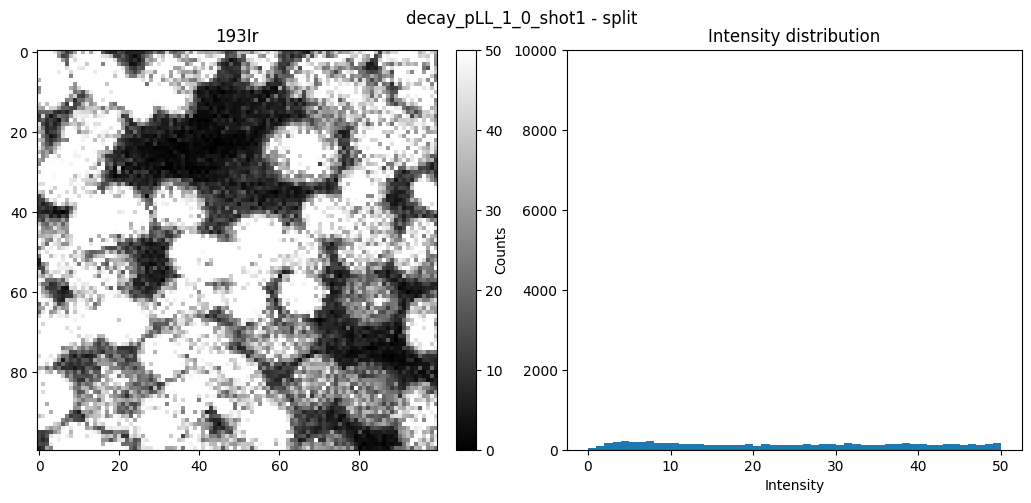

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


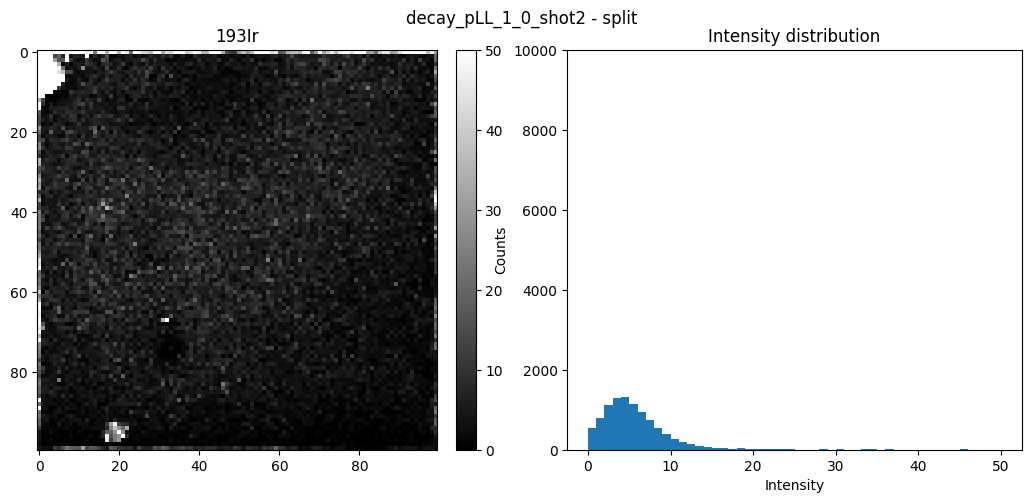

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


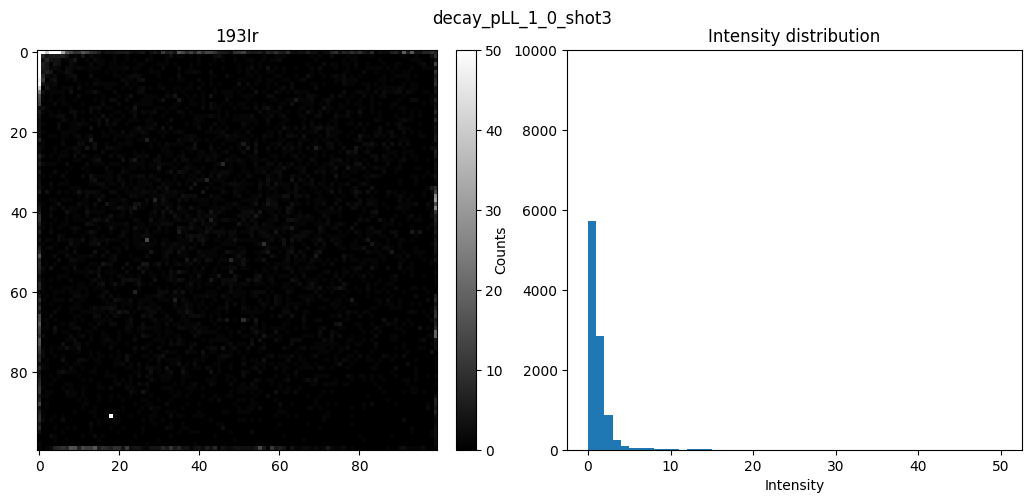

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


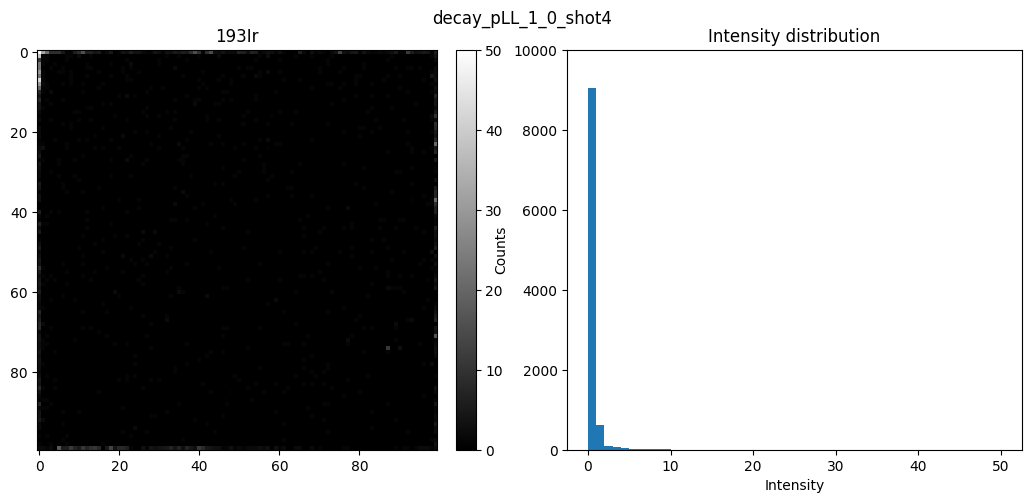

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


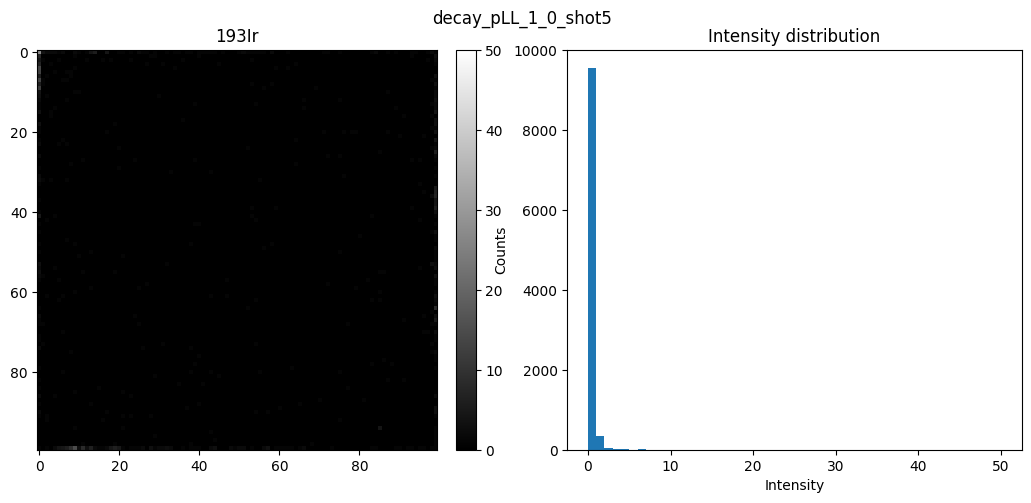

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


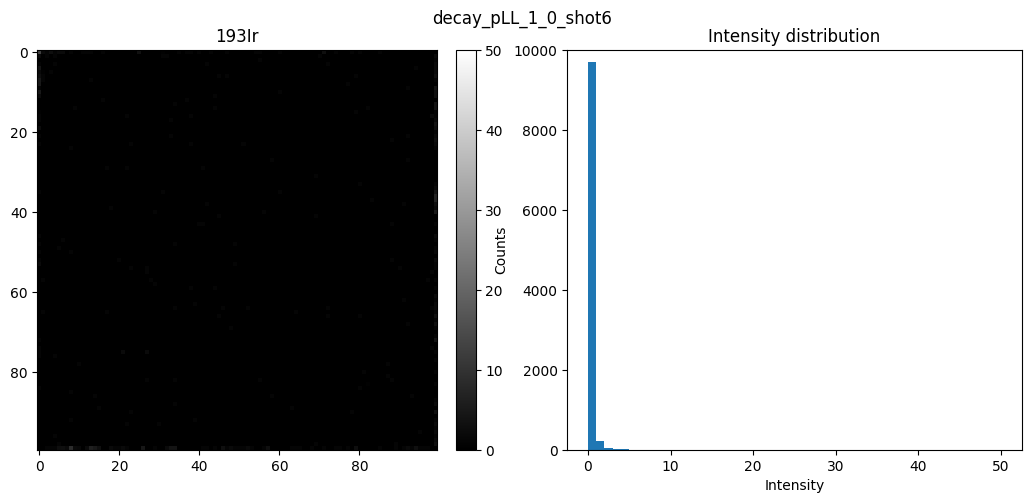

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


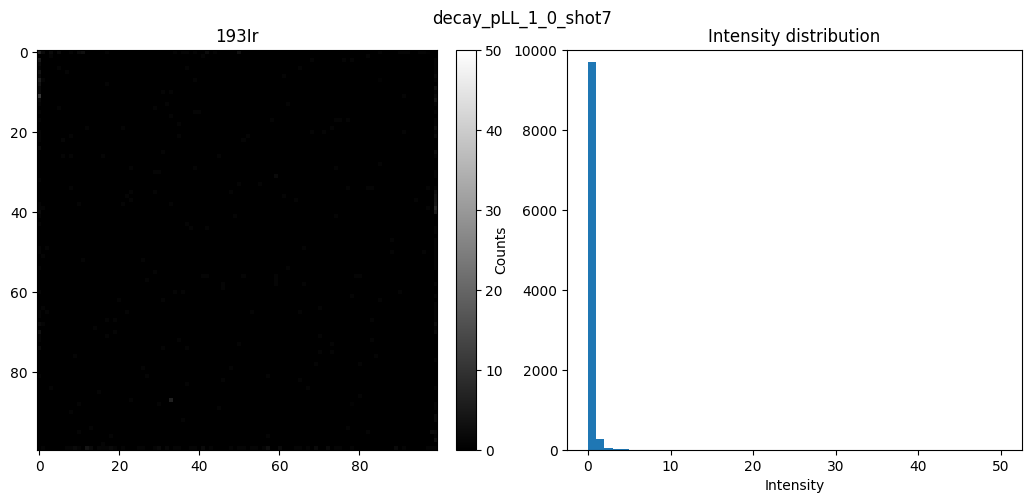

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


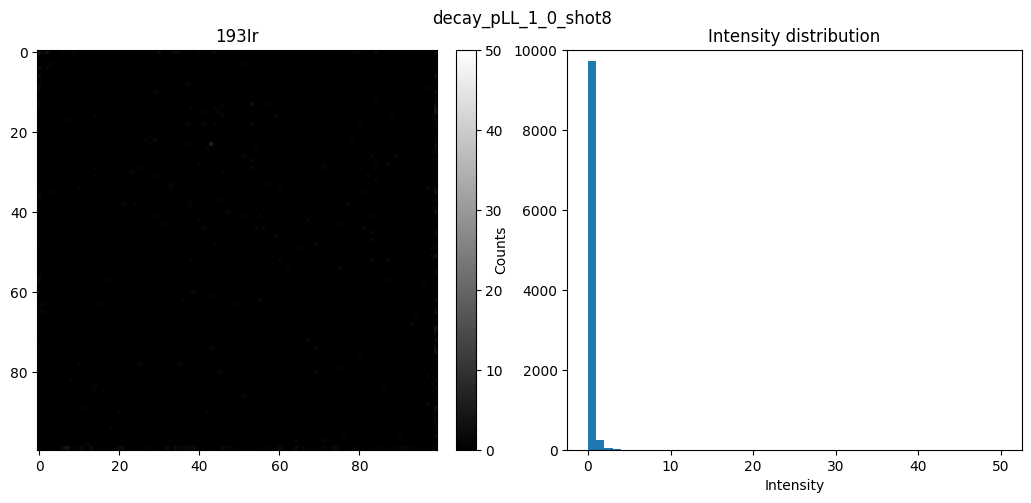

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


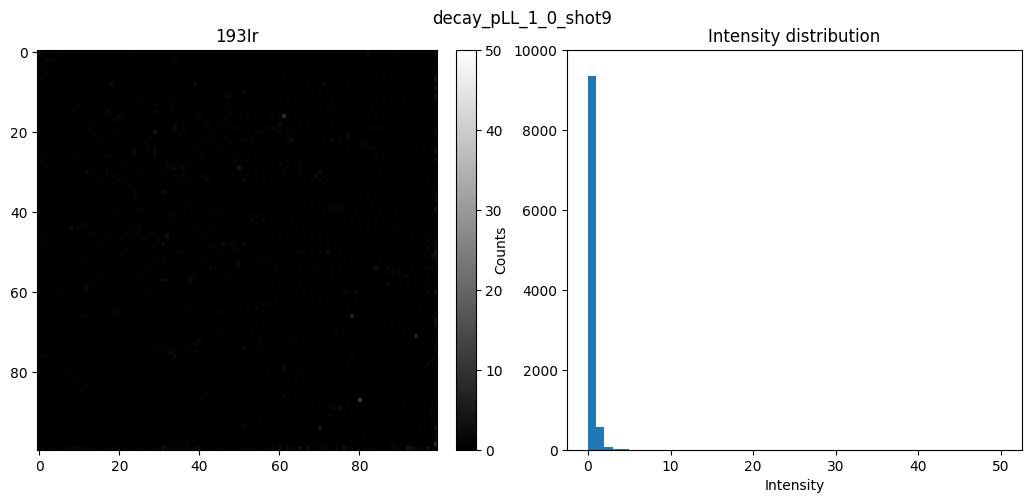

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


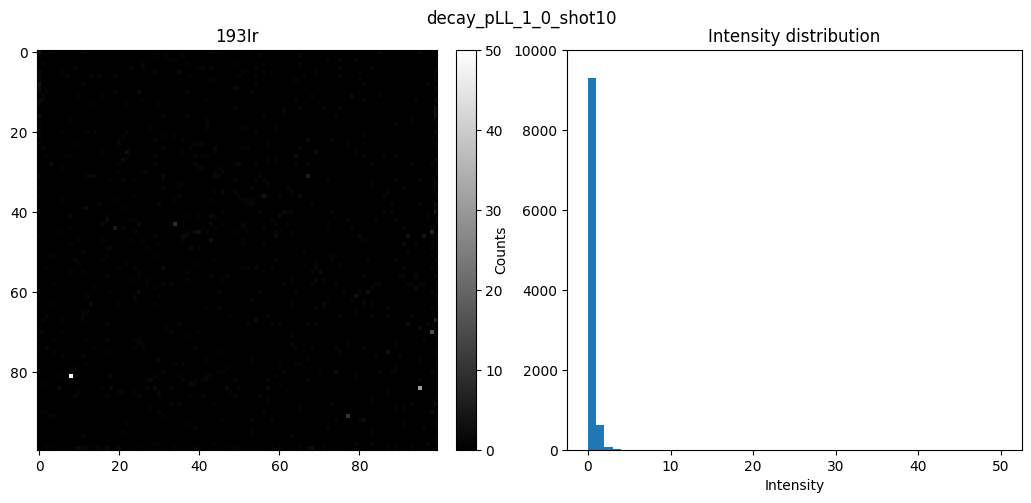

In [80]:
# create a new folder for saving the images
output_subdir = os.path.join(output_dir, power)
if not os.path.exists(output_subdir):
    os.makedirs(output_subdir)

# data frame
imc_193Ir_stats = pd.DataFrame(columns=['id', 'mean', 'median', 'std', 'min', 'max'])

# read image id from n to n+10, plot the images
for id in decay_dict[power]:
    imc_dict, channel_labels = read_imc_dict(file_big, id-2)
    img_imc = imc_dict['imc']
    
    # find the channel label
    chn_idx = channel_labels.index('193Ir_193Ir')
    
    plot_imc_nuc(img_imc, imc_dict, chn_idx, 50, output_subdir)
    
    # get statistics of the image with the channel label
    img_imc_193Ir = img_imc[chn_idx, :, :]
    mean = np.mean(img_imc_193Ir)
    median = np.median(img_imc_193Ir)
    std = np.std(img_imc_193Ir)
    min = np.min(img_imc_193Ir)
    max = np.max(img_imc_193Ir)
    
    # add the statistics to the data frame
    imc_193Ir_stats.loc[len(imc_193Ir_stats)] = [id, mean, median, std, min, max]
    

In [81]:
imc_193Ir_stats

,id,mean,median,std,min,max
0,54.0,38.355427,35.50,30.084520,0.0,1119.00
1,55.0,6.804900,4.75,24.408072,0.0,2006.75
2,56.0,0.941150,0.00,5.303752,0.0,312.00
3,57.0,0.234925,0.00,1.563171,0.0,82.50
4,58.0,0.078425,0.00,0.581780,0.0,27.00
5,59.0,0.046625,0.00,0.347214,0.0,13.00
6,60.0,0.043625,0.00,0.309379,0.0,11.50
7,61.0,0.036500,0.00,0.237076,0.0,5.25
8,62.0,0.080650,0.00,0.361795,0.0,10.25
9,63.0,0.102775,0.00,1.180305,0.0,106.75


In [84]:
decay_output_dir = os.path.join(output_dir, 'decay_curve')
if not os.path.exists(decay_output_dir):
    os.makedirs(decay_output_dir)

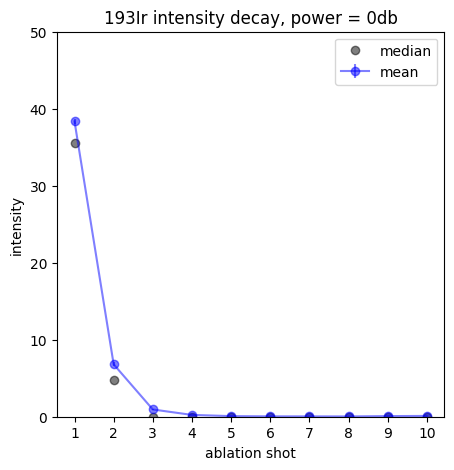

In [83]:
plt.figure(figsize=(5, 5))
plt.errorbar(range(1,11), imc_193Ir_stats['mean'], yerr=imc_193Ir_stats['std']/100, fmt='bo-', alpha = 0.5, label='mean')
# plot the median
plt.plot(range(1,11), imc_193Ir_stats['median'], 'ko', alpha = 0.5, label='median')
plt.legend()
# set x ticks manually, from 1 to 10
plt.xticks(range(1, 11))
plt.xlabel('ablation shot')
plt.ylabel('intensity')
plt.ylim(0, 50)
# set title
plt.title('193Ir intensity decay, power = ' + power)
# save 
plt.savefig(os.path.join(decay_output_dir, '193Ir_intensity_decay_' + power + '.png'))
plt.show()

## Image-level quantification, with nuclei-segmentation

To estimate the decay over multiple shot, quantify mean and median of each 100x100 image

In [95]:
power = '0db'

In [96]:
# create a new folder for saving the images
output_subdir = os.path.join(output_dir, power)
if not os.path.exists(output_subdir):
    os.makedirs(output_subdir)

# sum of all image (for segmentation)
img_nuc_sum = np.zeros((100, 100))
img_mem_sum = np.zeros((100, 100))

# data frame
imc_193Ir_stats = pd.DataFrame(columns=['id', 'mean', 'median', 'std', 'min', 'max'])

sum over all decay images to get a "sum" image for segmentation.

In [97]:
decay_dict[power]

[54, 55, 56, 57, 58, 59, 60, 61, 62, 63]

In [98]:
# read image id from n to n+10, plot the images
for id in decay_dict[power]:
    imc_dict, channel_labels = read_imc_dict(file_big, id-2)
    img_imc = imc_dict['imc']
    
    # find the channel label
    chn_idx = channel_labels.index('193Ir_193Ir')
    chc_idx = channel_labels.index('161Dy_TUBB3')
    
    # plot_imc_nuc(img_imc, imc_dict, chn_idx, 50, output_subdir)

    img_imc_193Ir = img_imc[chn_idx, :, :]
    img_nuc_sum = img_nuc_sum + img_imc_193Ir
    
    img_imc_Dy161 = img_imc[chc_idx, :, :]
    img_mem_sum = img_mem_sum + img_imc_Dy161
    

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Ready for segmentation

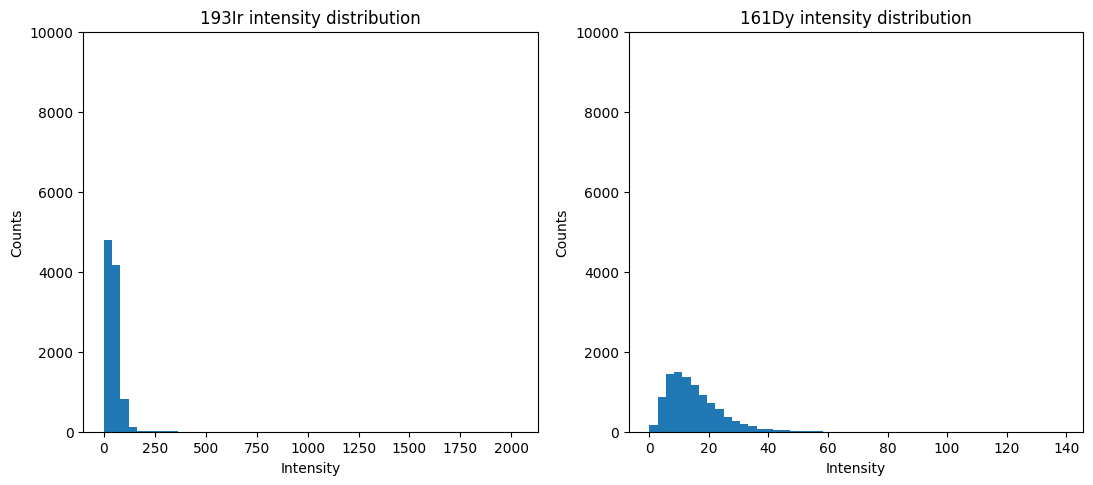

In [99]:
# plot histogram showing the intensity distribution of the sum of all images
plt.figure(figsize=(10, 5))
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
plt.subplot(1, 2, 1)
# histogram of the sum of all images
plt.hist(img_nuc_sum.flatten(), bins=50, range=(0, np.max(img_nuc_sum)))
plt.ylim(0, 10000)
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title('193Ir intensity distribution')

plt.subplot(1, 2, 2)
# histogram of the sum of all images
plt.hist(img_mem_sum.flatten(), bins=50, range=(0, np.max(img_mem_sum)))
plt.ylim(0, 10000)
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title('161Dy intensity distribution')

plt.show()

In [102]:
# remove outlier pixel, push all the pixel value larger than specified value to the specified value
def remove_outlier(img, value):
    img[img > value] = value
    return img

# remove the outlier pixel
img_nuc_sum = remove_outlier(img_nuc_sum, 200)
img_mem_sum = remove_outlier(img_mem_sum, 60)

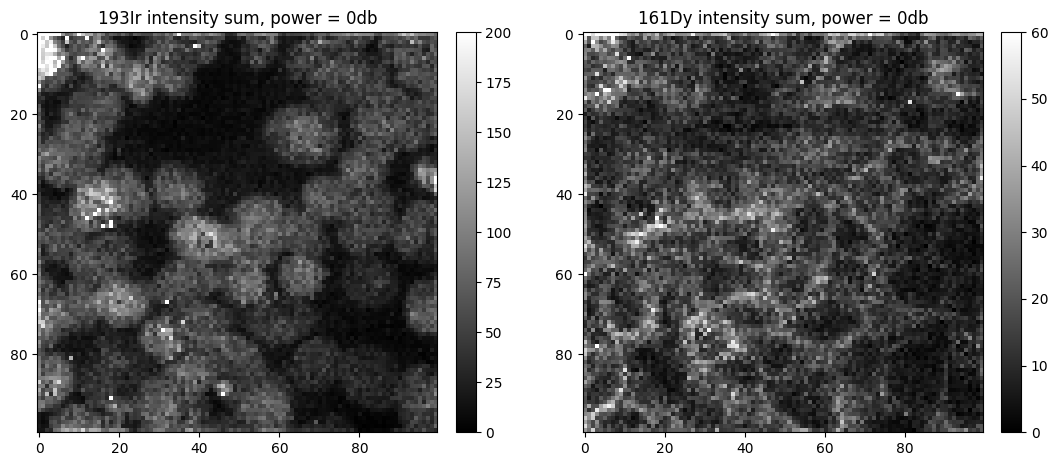

In [103]:
# plot img_sum_nuc and img_sum_mem
plt.figure(figsize=(10, 5))
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
plt.subplot(1, 2, 1)
plt.imshow(img_nuc_sum, cmap='gray')
plt.axis('on')
plt.colorbar(fraction=0.0458, pad=0.04)
plt.clim(0, np.max(img_nuc_sum))
plt.title('193Ir intensity sum, power = ' + power)
plt.subplot(1, 2, 2)
plt.imshow(img_mem_sum, cmap='gray')
plt.axis('on')
plt.colorbar(fraction=0.0458, pad=0.04)
plt.clim(0, np.max(img_mem_sum))
plt.title('161Dy intensity sum, power = ' + power)
plt.show()


### Deepcell segmentation

Load packages and models

In [18]:
from deepcell.datasets import TissueNetSample
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay

In [19]:
from deepcell.applications import Mesmer
os.environ.update({"DEEPCELL_ACCESS_TOKEN": "sUtUi5rR.2Le1SxO2alk3NvxCdvEqSujc3xYwxZvM"})

app = Mesmer()

INFO:root:Checking for cached data
INFO:root:Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
INFO:root:MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
INFO:root:Extracting C:\Users\asus\.deepcell\models\MultiplexSegmentation-9.tar.gz
INFO:root:Successfully extracted C:\Users\asus\.deepcell\models\MultiplexSegmentation-9.tar.gz into C:\Users\asus\.deepcell\models


In [20]:
def plot_overlay(rgb_images, overlay_data):
    idx = 0

    # plot the data
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(rgb_images[idx, ...])
    ax[1].imshow(overlay_data[idx, ...])

    ax[0].set_title('Raw data')
    ax[1].set_title('Predictions')

    for a in ax:
        a.axis('off')

    plt.show()

In [21]:
def plot_imc_nuc_with_overlays(img_imc, imc_dict, chn_idx, colim, output_subdir, nuc_mask):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
    plt.subplot(1, 2, 1)
    plt.imshow(img_imc[chn_idx, :, :] + 5*nuc_mask, cmap='gray')
    plt.axis('on')
    # set the colorbar
    plt.colorbar(fraction=0.0458, pad=0.04)
    # set dynamic range 
    plt.clim(0, colim)
    # add subtitle
    plt.title('193Ir')   
    
    plt.subplot(1, 2, 2)
    # plot the histogram of intensity
    plt.hist(img_imc[chn_idx, :, :][nuc_mask == 1].flatten(), bins=50, range=(0, colim))
    plt.ylim(0, 10000)
    # add x and y labels
    plt.xlabel('Intensity')
    plt.ylabel('Counts')
    plt.title('Intensity distribution')
    
    # add the plot title
    plt.suptitle(imc_dict['description'])
    
    # save the plot
    plt.savefig(output_subdir + "\\" + imc_dict['description'] + ".png")
    plt.show()

In [22]:
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.5 microns per pixel


Training resolution is 0.5 micron, smaller the decay images. Thus we oversample img_sum to match the scale.

In [104]:
img_nuc_sum_upsampled = scipy.ndimage.zoom(img_nuc_sum, 2, order=1) # order 0 is nearest-neighbor interpolation, order 1 is bilinear, order 2 is cubic
img_mem_sum_upsampled = scipy.ndimage.zoom(img_mem_sum, 2, order=1)

# put the images into a 4D np array
# [1, x, y, channel]
img_sum_upsampled = np.stack([img_nuc_sum_upsampled, img_mem_sum_upsampled], axis=-1)
img_sum_upsampled = np.expand_dims(img_sum_upsampled, axis=0)

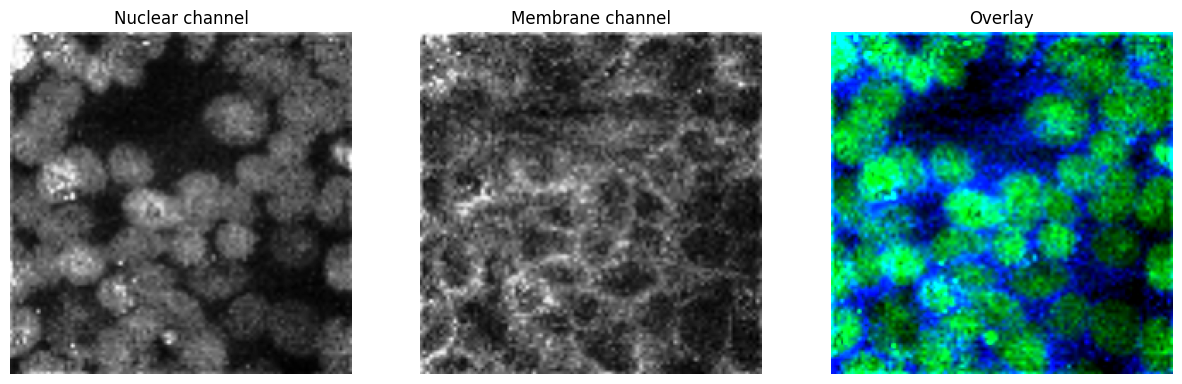

In [105]:
rgb_images = create_rgb_image(img_sum_upsampled, channel_colors=['green', 'blue'])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_sum_upsampled[0, ..., 0], cmap='Greys_r')
ax[1].imshow(img_sum_upsampled[0, ..., 1], cmap='Greys_r')
ax[2].imshow(rgb_images[0, ...])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

for a in ax:
    a.axis('off')

plt.show()

In [106]:
img_sum_upsampled_seg_mem = app.predict(img_sum_upsampled, image_mpp=0.5) # membrane segmentation
img_sum_upsampled_seg_nuc = app.predict(img_sum_upsampled, image_mpp=0.5, compartment = 'nuclear')

In [107]:
overlay_mem_data = make_outline_overlay(rgb_data=rgb_images, predictions=img_sum_upsampled_seg_mem)
overlay_nuc_data = make_outline_overlay(rgb_data=rgb_images, predictions=img_sum_upsampled_seg_nuc)

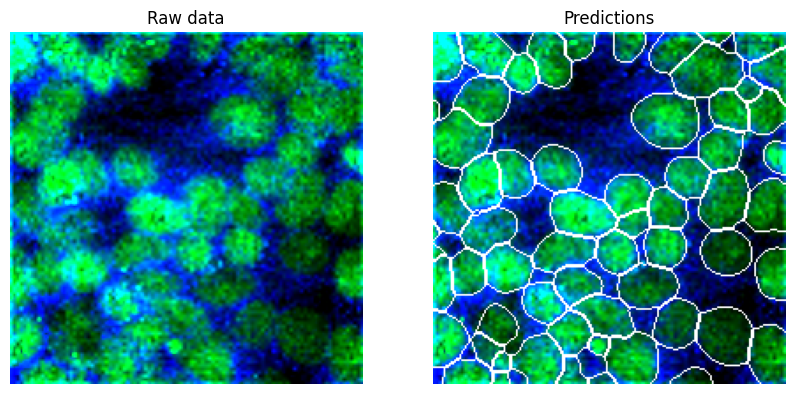

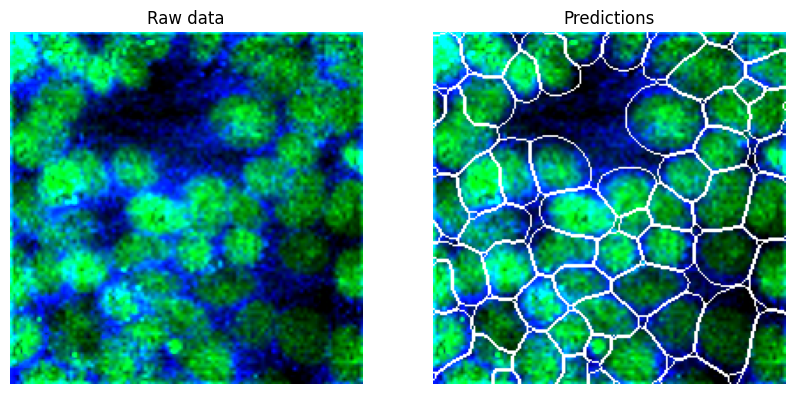

In [108]:
# show rgb image with overlays
plot_overlay(rgb_images, overlay_nuc_data)
plot_overlay(rgb_images, overlay_mem_data)

Convert the nuc segmentation result into binary mask

Nuclear segmentation shape: (1, 200, 200, 1)


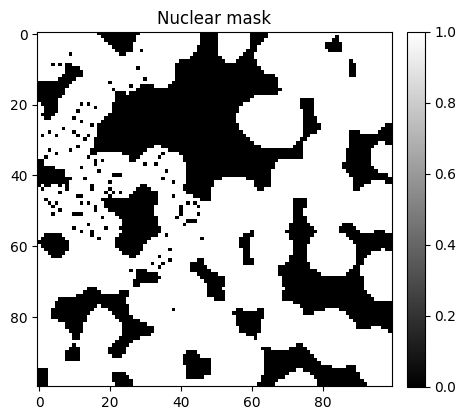

In [109]:
print('Nuclear segmentation shape:', img_sum_upsampled_seg_nuc.shape)
nuc_mask = img_sum_upsampled_seg_nuc[0, ..., 0] > 0

nuc_mask = scipy.ndimage.zoom(nuc_mask, 0.5, order=1)

plt.figure(figsize=(5, 5))
plt.imshow(nuc_mask, cmap='gray')
plt.axis('on')
plt.colorbar(fraction=0.0458, pad=0.04)
plt.title('Nuclear mask')
plt.show()

Remove small dark features (similar to fill holes but only those noisy dark pixels)

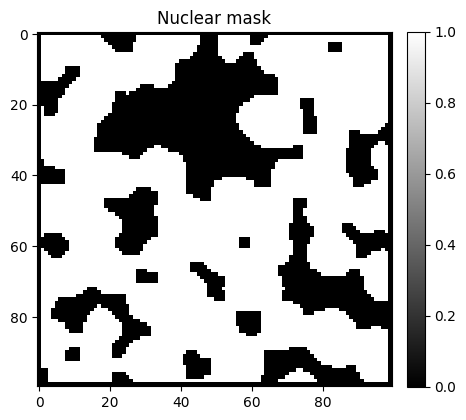

In [110]:
# remove isolated dark spots, close and open the mask
nuc_mask = scipy.ndimage.binary_closing(nuc_mask, structure=np.ones((3,3)))

plt.figure(figsize=(5, 5))
plt.imshow(nuc_mask, cmap='gray')
plt.axis('on')
plt.colorbar(fraction=0.0458, pad=0.04)
plt.title('Nuclear mask')
plt.show()

### Masked pixel-level decay estimation

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


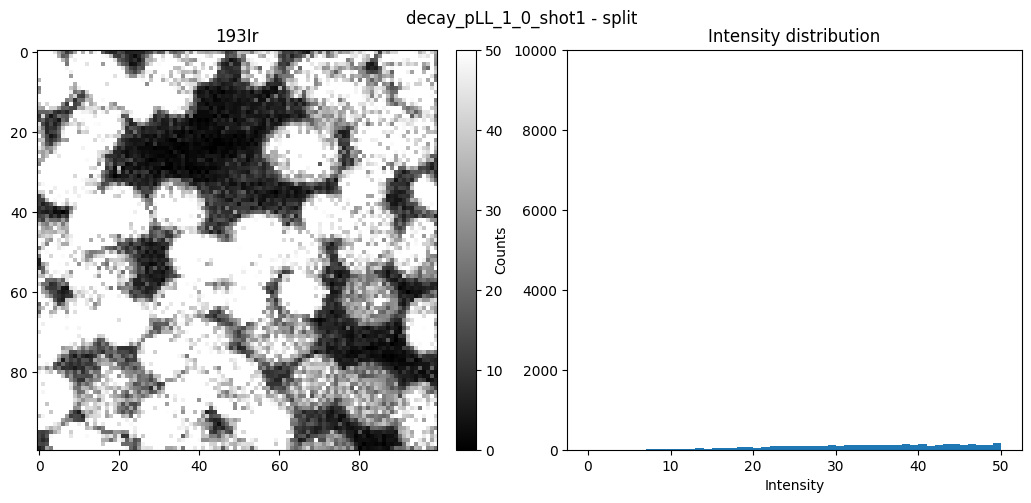

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


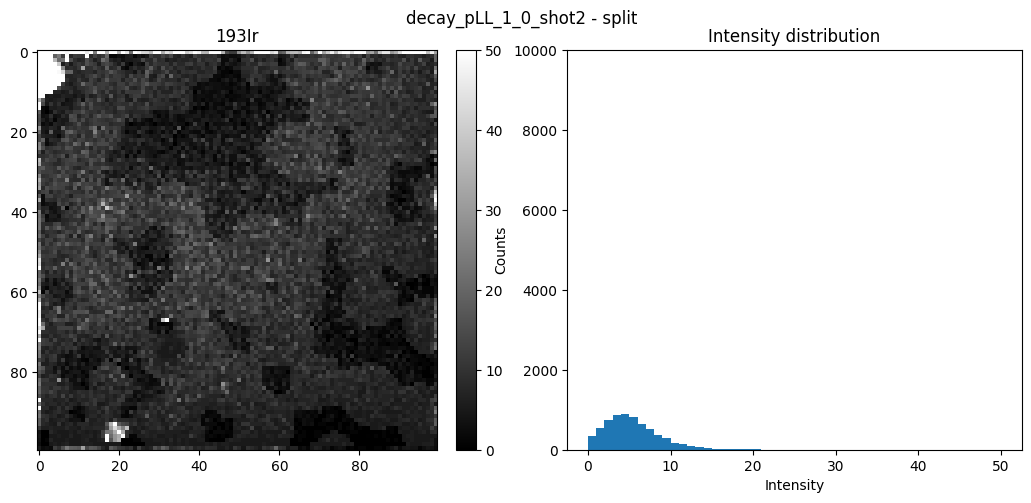

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


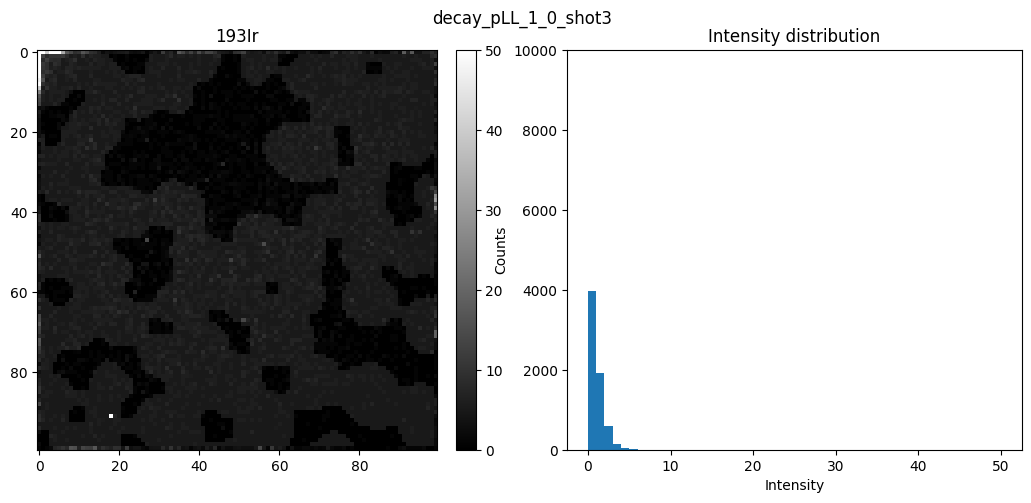

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


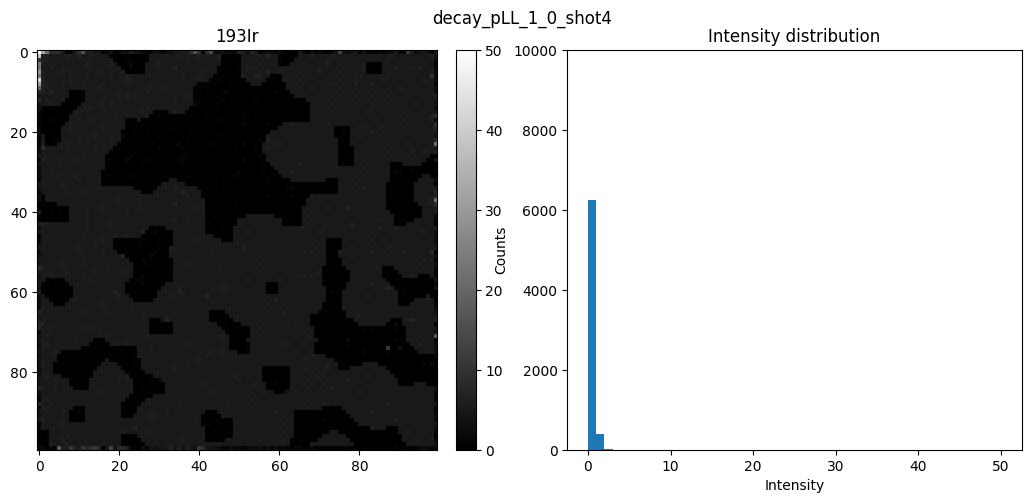

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


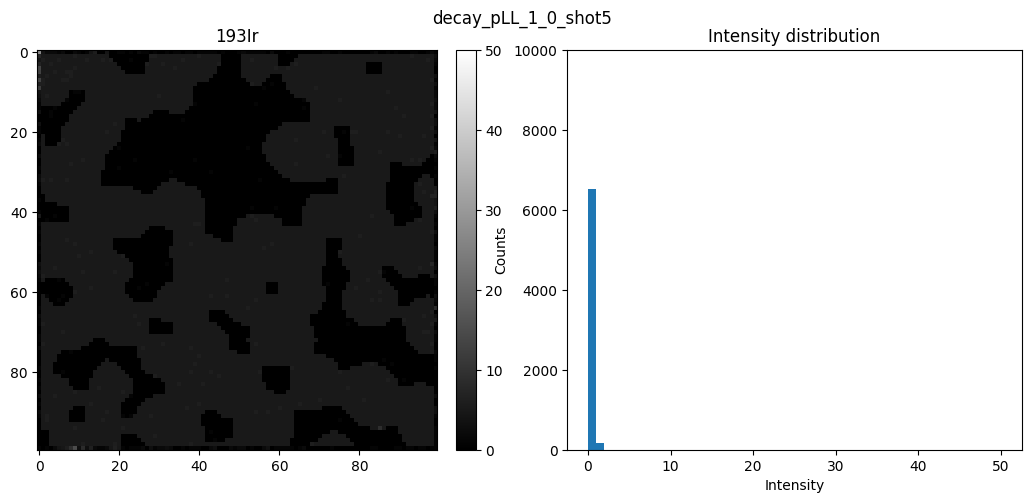

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


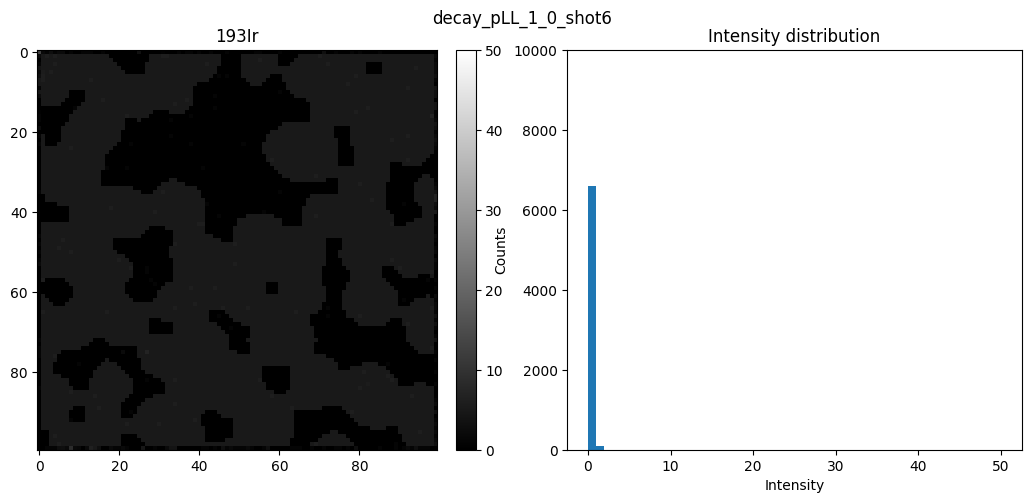

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


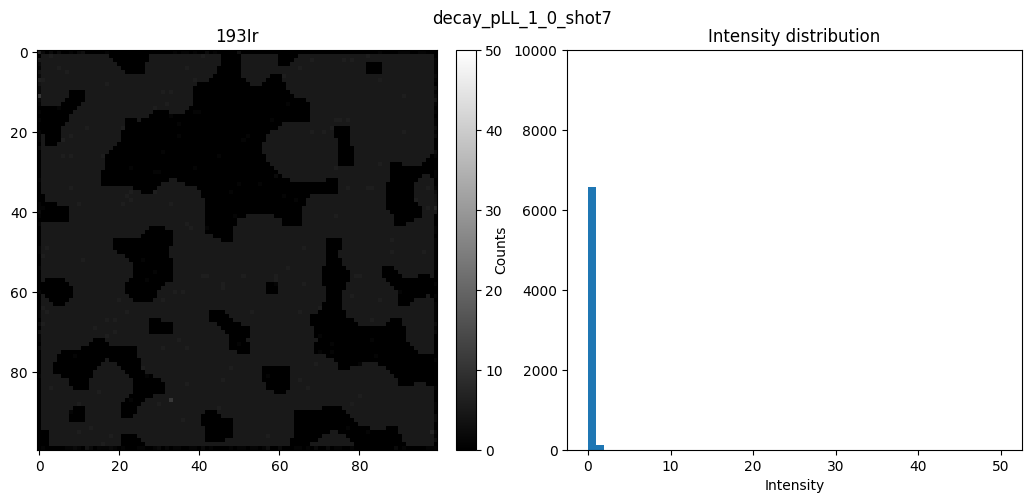

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


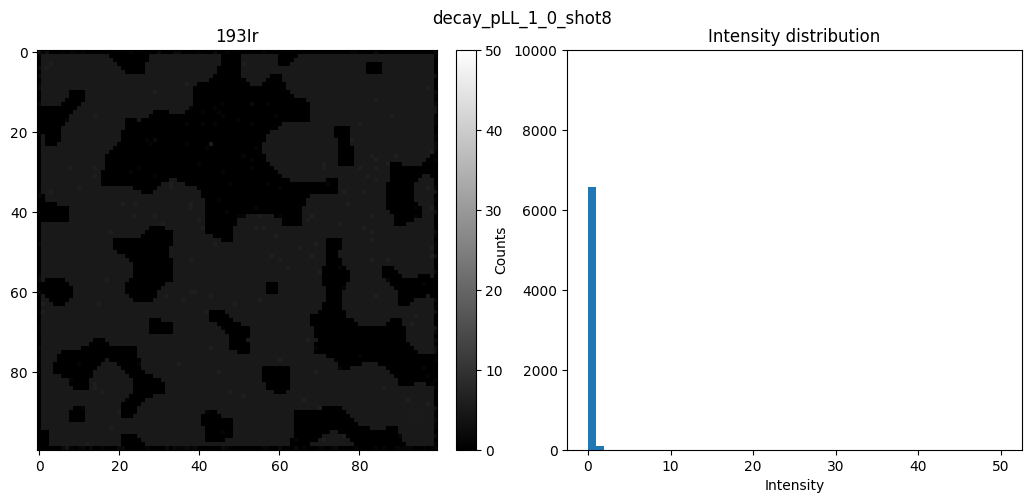

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


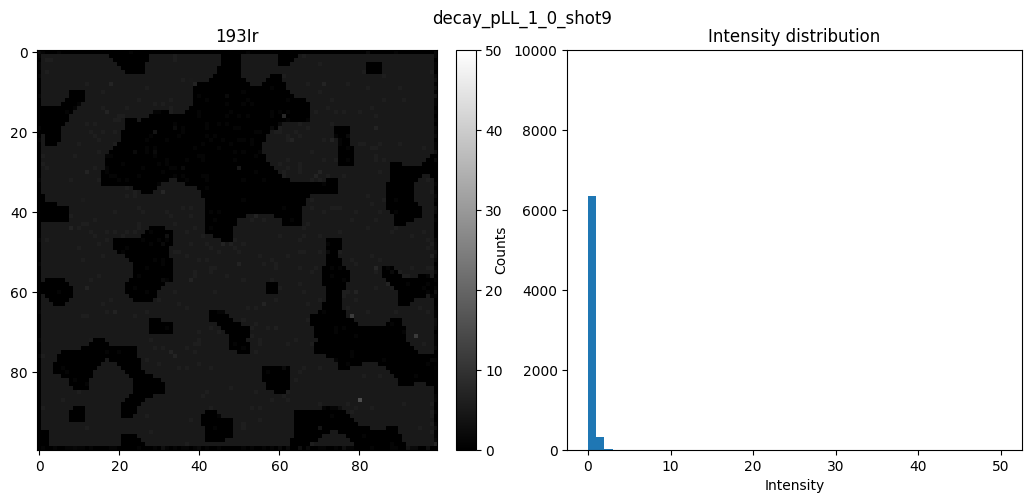

c:\Users\asus\anaconda3\envs\IMCanalysis\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


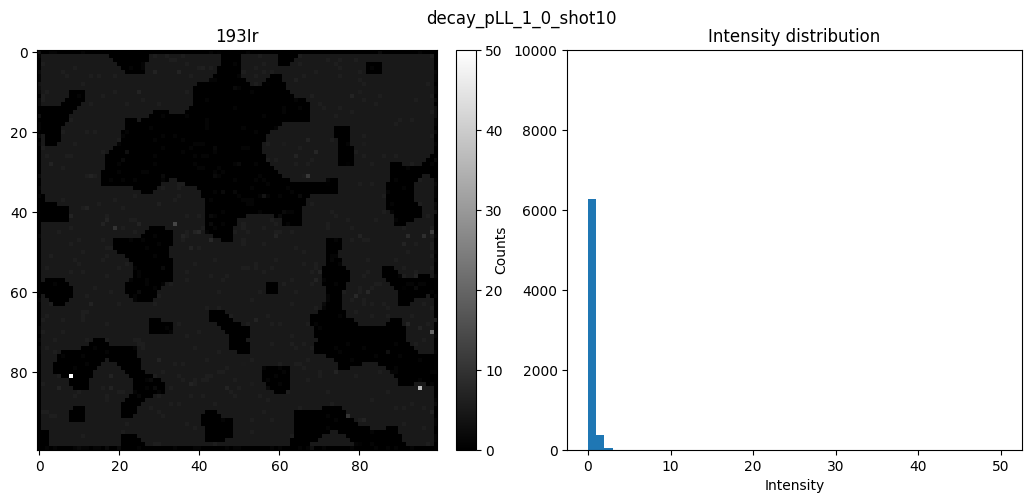

In [111]:
# create a new folder for saving the images
output_subdir = os.path.join(output_dir, power+'_masked')
if not os.path.exists(output_subdir):
    os.makedirs(output_subdir)

# data frame
imc_193Ir_stats = pd.DataFrame(columns=['id', 'mean', 'median', 'std', 'min', 'max'])

# read image id from n to n+10, plot the images
for id in decay_dict[power]:
    imc_dict, channel_labels = read_imc_dict(file_big, id-2)
    img_imc = imc_dict['imc']
    
    # find the channel label
    chn_idx = channel_labels.index('193Ir_193Ir')
    
    plot_imc_nuc_with_overlays(img_imc, imc_dict, chn_idx, 50, output_subdir, nuc_mask)
    
    # get statistics of the image with the channel label, only consider the region where nuc_mask is True
    img_imc_193Ir = img_imc[chn_idx, :, :]
    # mask and flatten the image
    img_imc_193Ir_masked = img_imc_193Ir[nuc_mask].flatten()
    mean = np.mean(img_imc_193Ir_masked)
    median = np.median(img_imc_193Ir_masked)
    std = np.std(img_imc_193Ir_masked)
    min = np.min(img_imc_193Ir_masked)
    max = np.max(img_imc_193Ir_masked)
    
    # add the statistics to the data frame
    imc_193Ir_stats.loc[len(imc_193Ir_stats)] = [id, mean, median, std, min, max]

In [112]:
imc_193Ir_stats

,id,mean,median,std,min,max
0,54.0,50.067234,46.75,28.879189,2.5,1119.00
1,55.0,6.375112,4.75,27.702745,0.0,2006.75
2,56.0,0.628031,0.00,3.907832,0.0,312.00
3,57.0,0.069403,0.00,0.276168,0.0,4.25
4,58.0,0.025404,0.00,0.166505,0.0,4.00
5,59.0,0.013469,0.00,0.117522,0.0,2.00
6,60.0,0.018183,0.00,0.152692,0.0,6.25
7,61.0,0.015676,0.00,0.124258,0.0,1.25
8,62.0,0.058777,0.00,0.298211,0.0,10.25
9,63.0,0.080440,0.00,0.536757,0.0,31.25


In [113]:
decay_output_dir = os.path.join(output_dir, 'decay_curve')
if not os.path.exists(decay_output_dir):
    os.makedirs(decay_output_dir)

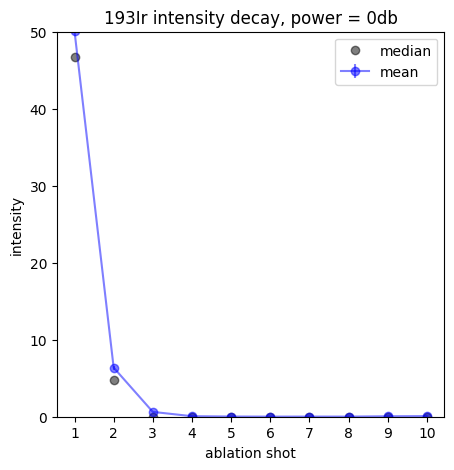

In [115]:
plt.figure(figsize=(5, 5))
plt.errorbar(range(1,11), imc_193Ir_stats['mean'], yerr=imc_193Ir_stats['std']/100, fmt='bo-', alpha = 0.5, label='mean')
# plot the median
plt.plot(range(1,11), imc_193Ir_stats['median'], 'ko', alpha = 0.5, label='median')
plt.legend()
# set x ticks manually, from 1 to 10
plt.xticks(range(1, 11))
plt.xlabel('ablation shot')
plt.ylabel('intensity')
plt.ylim(0, 50)
# set title
plt.title('193Ir intensity decay, power = ' + power)
# save 
plt.savefig(os.path.join(decay_output_dir, "193Ir_intensity_decay_" + power + "_masked.png"))
plt.show()

### Polynomial fitting

In [117]:
def ablation_decay_poly_fitting(shots, int_mean, degree):
    # shots: list of shot number
    # int_mean: list of mean intensity
    # degree: degree of the polynomial function
    # fit the data with polynomial function
    
    p = np.polyfit(shots, int_mean, degree)
    print('degree:', degree)
    print('fitting parameters:', p)
    
    return p

def ablation_decay_exp_fitting(shots, int_mean):
    # shots: list of shot number
    # int_mean: list of mean intensity
    # fit the data with exponential function
    
    p = np.polyfit(shots, np.log(int_mean), 1)
    print('fitting parameters:', p)
    
    return p

fitting parameters: [-2.20611495  6.17348112]


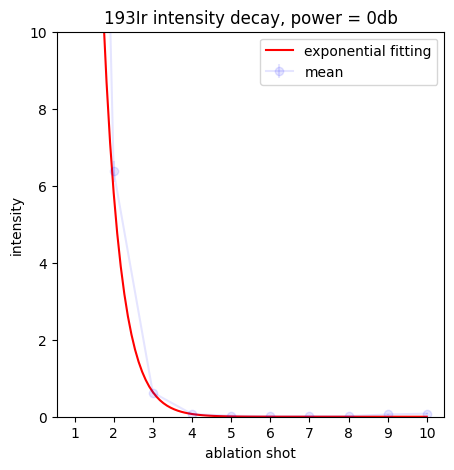

In [124]:
# for harsh ablation, only fit the first few datapoints
ndata = 4
shots = range(1, ndata+1)
int_mean = imc_193Ir_stats['mean'][0:ndata]
degree = 1

# p = ablation_decay_poly_fitting(shots, int_mean, degree)
p = ablation_decay_exp_fitting(shots, int_mean)

# plot the fitting curve with the data
plt.figure(figsize=(5, 5))
plt.errorbar(range(1,11), imc_193Ir_stats['mean'], yerr=imc_193Ir_stats['std']/100, fmt='bo-', alpha = 0.1, label='mean')
# plot the polynomial fitting curve
x = np.linspace(1, 10, 100)
y = np.polyval(p, x)
# plt.plot(x, y, 'r-', label='polynomial fitting, degree = ' + str(degree))
plt.plot(x, np.exp(np.polyval(p, x)), 'r-', label='exponential fitting')
plt.legend()
plt.xticks(range(1, 11))
plt.xlabel('ablation shot')
plt.ylabel('intensity')
plt.ylim(0, 10)
plt.title('193Ir intensity decay, power = ' + power)
plt.savefig(os.path.join(decay_output_dir, "193Ir_intensity_decay_" + power + "_masked_fitting.png"))
plt.show()

In [125]:
decay_coeff_dir = os.path.join(output_dir, 'decay_coeff')
if not os.path.exists(decay_coeff_dir):
    os.makedirs(decay_coeff_dir)

In [126]:
# save the degree and the fitting parameters to a csv file
df = pd.DataFrame(columns=['degree', 'coefficients'])
df.loc[len(df)] = [degree, p]
# df.to_csv(os.path.join(decay_coeff_dir, '193Ir_intensity_decay_' + power + '_masked_fitting_poly.csv'), index=False)
df.to_csv(os.path.join(decay_coeff_dir, '193Ir_intensity_decay_' + power + '_masked_fitting_exp.csv'), index=False)

In [ ]:
# read in
df = pd.read_csv(os.path.join(decay_coeff_dir, '193Ir_intensity_decay_' + power + '_masked_fitting_exp.csv'))
degree = df['degree'][0]
p = np.array(df['coefficients'][0].strip('[]').split()).astype(float)
